6.069 mm


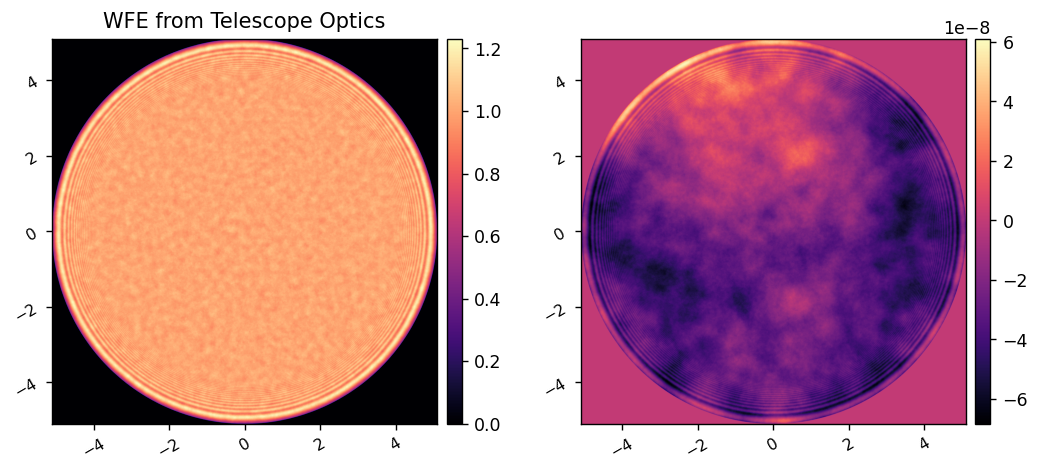

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, agpm
reload(full)

from wfsc_1dm import utils

from imshows import *

pupil_diam = 10.2*u.mm
focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam * focal_ratio
print(lyot_diam)

wavelength_c = 650e-9*u.m

reload(agpm)
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2)

ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix))

In [19]:
256*16

4096

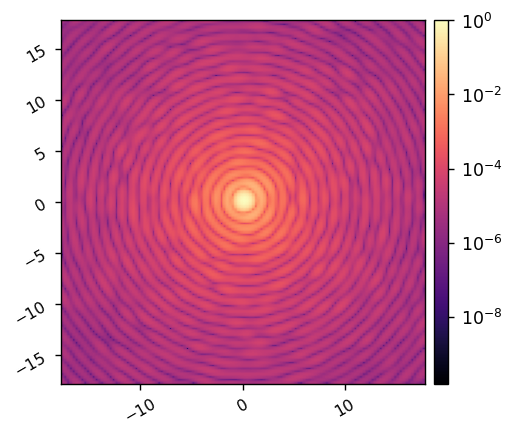

In [2]:
reload(full)
poppy_log.disabled = True

c = full.CORO()

c.npix = 512
c.oversample = 16
c.npsf = 128

c.OTEWFE = OTE_WFE

c.use_opds = False
c.use_opds = True

c.im_norm = c.snap().max()

ref_im = c.snap()
imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, lognorm=True)




In [20]:
650/750 * 4.2

3.64

In [15]:
c.wavelength_c

<Quantity 6.5e-07 m>

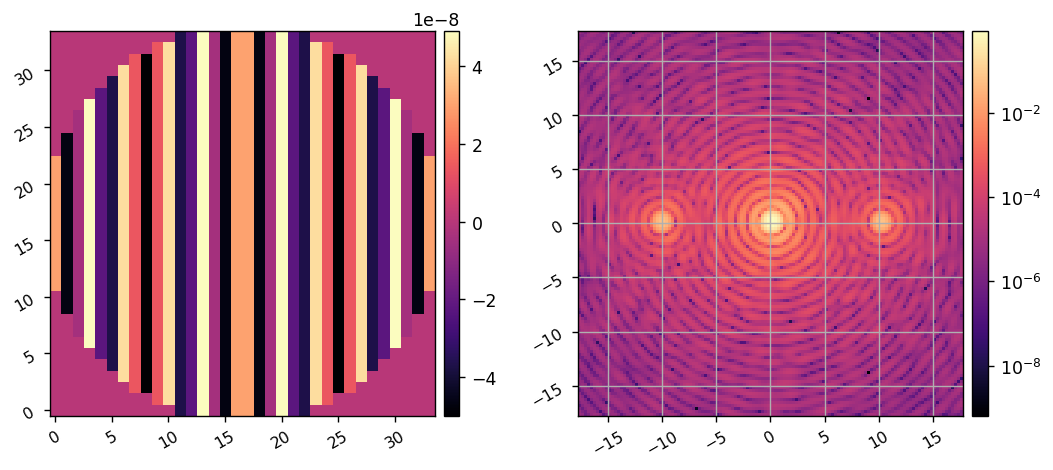

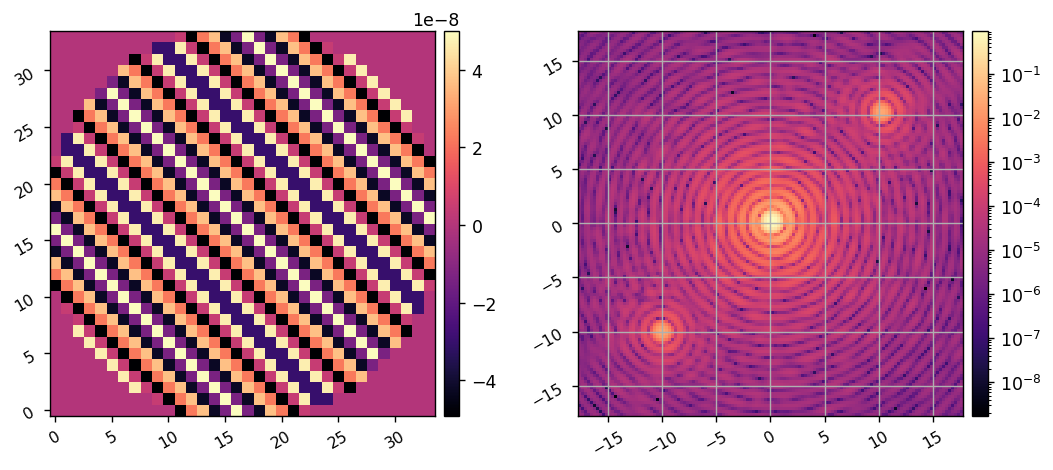

In [3]:
poppy_log.disabled = True

c.use_opds = False
c.use_opds = True

Nact = c.Nact
xpp = np.linspace(-c.Nact/2, c.Nact/2-1, c.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 5e-8

separation = 10
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*c.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*c.dm_mask

c.set_dm(com_1)
im1 = c.snap()
imshow2(c.get_dm(), im1, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

c.set_dm(com_2)
im2 = c.snap()
imshow2(c.get_dm(), im2, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

In [4]:
!nvidia-smi

Tue Jun 27 17:42:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   32C    P0               63W / 300W|  32265MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

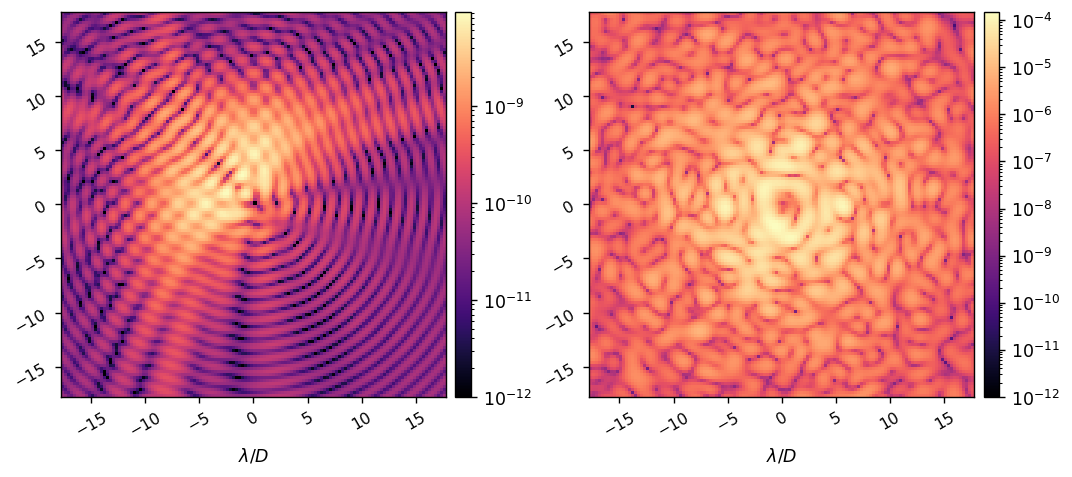

In [5]:
poppy_log.disabled = True

c.reset_dm()

c.FPM = vortex
c.LYOT = lyot_stop

c.use_opds = False
occ_im_no_opds = c.snap()

c.use_opds = True
occ_im_with_opds = c.snap()

imshow2(occ_im_no_opds, occ_im_with_opds,
        pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, 
        vmin1=1e-12, vmin2=1e-12)



# Check difference in speckle field with two different WFE datasets from the telescope optics

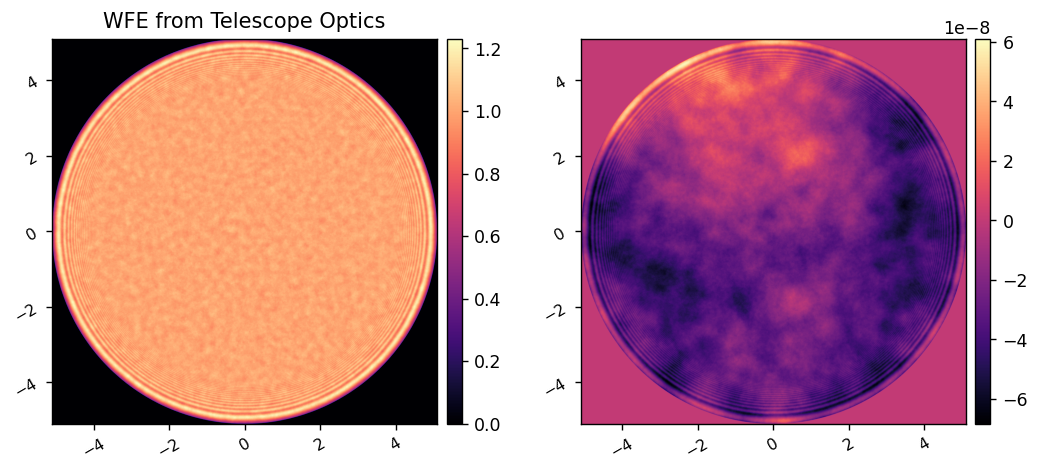

FileNotFoundError: [Errno 2] No such file or directory: 'ote-wfe-data/telescope_wfe_2.fits'

In [43]:
ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE_1 = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE_1.amplitude,OTE_WFE_1.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE_1.pixelscale.to(u.mm/u.pix))

ote_wfe_fname = 'ote-wfe-data/telescope_wfe_2.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE_2 = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE_2.amplitude, OTE_WFE_2.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE_2.pixelscale.to(u.mm/u.pix))

reload(full)
c = full.CORO()

c.npix = 256
c.oversample = 16
c.use_opds = True

c.APODIZER = None
c.FPM = vortex
c.LYOT = lyot_stop

c.OTEWFE = OTE_WFE_1
im1=c.snap()

c.OTEWFE = OTE_WFE_2
im2=c.snap()


imshow3(im1, im2, im1-im2, lognorm1=True, lognorm2=True)